    Unique_ID : Unique Identifier.
    Name : Name of the Artist.
    Genre : Genre of the Song.
    Country : Origin Country of Artist.
    Song_Name : Name of the Song.
    Timestamp : Release Date and Time.
    Views : Number of times the song was played/viewed (Target/Dependent Variable).
    Comments : Count of comments for the song.
    Likes : Count of Likes.
    Popularity : Popularity score for the artist.
    Followers : Number of Followers.

# Import libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from tqdm.notebook import tqdm
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

# Import datasets

In [2]:
train = pd.read_csv('/kaggle/input/Data_Train.csv')
test = pd.read_csv('/kaggle/input/Data_Test.csv')
sub = pd.read_csv('/kaggle/input/Sample_Submission.csv')

In [3]:
train.shape, test.shape, sub.shape

((78458, 11), (19615, 10), (19615, 2))

# Data exploration

In [4]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [5]:
train.head(2)

,Unique_ID,Name,Genre,Country,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers
0,413890,Hardstyle,danceedm,AU,N-Vitral presents BOMBSQUAD - Poison Spitter (...,2018-03-30 15:24:45.000000,14017,4,499,97,119563
1,249453,Dj Aladdin,danceedm,AU,Dj Aladdin - Old School Hip Hop Quick Mix,2016-06-20 05:58:52.000000,1918,17,49,17,2141


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78458 entries, 0 to 78457
Data columns (total 11 columns):
Unique_ID     78458 non-null int64
Name          78458 non-null object
Genre         78458 non-null object
Country       78458 non-null object
Song_Name     78457 non-null object
Timestamp     78458 non-null object
Views         78458 non-null int64
Comments      78458 non-null int64
Likes         78458 non-null object
Popularity    78458 non-null object
Followers     78458 non-null int64
dtypes: int64(4), object(7)
memory usage: 6.6+ MB


In [7]:
train.isnull().sum()

Unique_ID     0
Name          0
Genre         0
Country       0
Song_Name     1
Timestamp     0
Views         0
Comments      0
Likes         0
Popularity    0
Followers     0
dtype: int64

In [8]:
train.nunique()

Unique_ID     78458
Name           1209
Genre            21
Country           1
Song_Name     78457
Timestamp     68187
Views         53964
Comments       2152
Likes          9214
Popularity     5719
Followers      1153
dtype: int64

In [9]:
test.nunique()

Unique_ID     19615
Name           1115
Genre            21
Country           1
Song_Name     19615
Timestamp     17810
Comments       1123
Likes          5415
Popularity     2989
Followers      1081
dtype: int64

# Data pre-processing

In [10]:
train['Timestamp'] = pd.to_datetime(train['Timestamp'])
test['Timestamp'] = pd.to_datetime(test['Timestamp'])

train = train.sort_values('Timestamp').reset_index(drop = True)
test = test.sort_values('Timestamp').reset_index(drop = True)

In [11]:
df = train.append(test, ignore_index=True, sort=False)
df.shape

(98073, 11)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98073 entries, 0 to 98072
Data columns (total 11 columns):
Unique_ID     98073 non-null int64
Name          98073 non-null object
Genre         98073 non-null object
Country       98073 non-null object
Song_Name     98072 non-null object
Timestamp     98073 non-null datetime64[ns]
Views         78458 non-null float64
Comments      98073 non-null int64
Likes         98073 non-null object
Popularity    98073 non-null object
Followers     98073 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 8.2+ MB


In [13]:
df.head(2)

,Unique_ID,Name,Genre,Country,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers
0,1120672,Queen,rock,AU,Liar (At The BBC),1973-01-01,87.0,0,0,0,70299
1,1120675,Queen,rock,AU,Great King Rat,1973-01-01,104.0,0,0,0,70299


In [14]:
df['Other_artist'] = df['Song_Name'].str.count('feat|Feat|FEAT')

In [15]:
df['Year'] = pd.to_datetime(df['Timestamp']).dt.year
df['Month'] = pd.to_datetime(df['Timestamp']).dt.month
df['Day'] = pd.to_datetime(df['Timestamp']).dt.day
df['Hour'] = pd.to_datetime(df['Timestamp']).dt.hour
df['Minutes'] = pd.to_datetime(df['Timestamp']).dt.minute
df['Seconds'] = pd.to_datetime(df['Timestamp']).dt.second
df['Dayofweek'] = pd.to_datetime(df['Timestamp']).dt.dayofweek
df['DayOfyear'] = pd.to_datetime(df['Timestamp']).dt.dayofyear
df['WeekOfyear'] = pd.to_datetime(df['Timestamp']).dt.weekofyear

In [16]:
df['Likes'] = df['Likes'].str.replace(',','')
df['Likes'] = df['Likes'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval) 

In [17]:
df['Popularity'] = df['Popularity'].str.replace(',','')
df['Popularity'] = df['Popularity'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval) 

In [18]:
agg_func = {
    'Comments': ['sum'],
    'Likes': ['sum'],
    'Popularity': ['sum'],
    'Followers': ['sum']
}
agg_name = df.groupby(['Year','Name']).agg(agg_func)
agg_name.columns = [ 'YN_' + ('_'.join(col).strip()) for col in agg_name.columns.values]
agg_name.reset_index(inplace=True)
df = df.merge(agg_name, on=['Year','Name'], how='left')
del agg_name

In [19]:
agg_func = {
    'Comments': ['mean','min','max','sum','median'],
    'Likes': ['mean','min','max','sum','median'],
    'Popularity': ['mean','min','max','sum','median'],
    'Followers': ['mean','sum']
}
agg_name = df.groupby('Name').agg(agg_func)
agg_name.columns = [ 'Name_' + ('_'.join(col).strip()) for col in agg_name.columns.values]
agg_name.reset_index(inplace=True)
df = df.merge(agg_name, on=['Name'], how='left')
del agg_name

In [20]:
df['Followers / Popularity'] = df['Followers'] / df['Popularity']
df['Followers / Comments'] = df['Followers'] / df['Comments']
df['Followers / Likes'] = df['Followers'] / df['Likes']

df['Popularity / Followers'] = df['Popularity'] / df['Followers']
df['Popularity / Comments'] = df['Popularity'] / df['Comments']
df['Popularity / Likes'] = df['Popularity'] / df['Likes']

df['Likes / Followers'] = df['Likes'] / df['Followers']
df['Likes / Popularity'] = df['Likes'] / df['Popularity']
df['Likes / Comments'] = df['Likes'] / df['Comments']

In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Name'] = le.fit_transform(df['Name'])

In [22]:
df = pd.get_dummies(df, columns=['Genre'], drop_first=True)

In [23]:
df.drop(['Country','Song_Name','Timestamp'], axis=1, inplace=True)

In [24]:
train_df = df[df['Views'].isnull()!=True]
test_df = df[df['Views'].isnull()==True]
test_df.drop('Views', axis=1, inplace=True)

In [25]:
train_df = train_df.replace([np.inf, -np.inf], np.nan)
train_df = train_df.fillna(0)

test_df = test_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.fillna(0)

In [26]:
train_df.shape, test_df.shape

((78458, 67), (19615, 66))

# Train test split

In [27]:
X = train_df.drop(labels=['Views'], axis=1)
y = train_df['Views'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=42)

In [28]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((58843, 66), (58843,), (19615, 66), (19615,))

In [29]:
X_train.tail(2)

,Unique_ID,Name,Comments,Likes,Popularity,Followers,Other_artist,Year,Month,Day,Hour,Minutes,Seconds,Dayofweek,DayOfyear,WeekOfyear,YN_Comments_sum,YN_Likes_sum,YN_Popularity_sum,YN_Followers_sum,Name_Comments_mean,Name_Comments_min,Name_Comments_max,Name_Comments_sum,Name_Comments_median,Name_Likes_mean,Name_Likes_min,Name_Likes_max,Name_Likes_sum,Name_Likes_median,Name_Popularity_mean,Name_Popularity_min,Name_Popularity_max,Name_Popularity_sum,Name_Popularity_median,Name_Followers_mean,Name_Followers_sum,Followers / Popularity,Followers / Comments,Followers / Likes,Popularity / Followers,Popularity / Comments,Popularity / Likes,Likes / Followers,Likes / Popularity,Likes / Comments,Genre_alternativerock,Genre_ambient,Genre_classical,Genre_country,Genre_danceedm,Genre_deephouse,Genre_disco,Genre_drumbass,Genre_dubstep,Genre_electronic,Genre_folksingersongwriter,Genre_hiphoprap,Genre_indie,Genre_latin,Genre_metal,Genre_pop,Genre_rbsoul,Genre_reggaeton,Genre_rock,Genre_trap
860,1120298,782,0,5.0,3.0,70299,0.0,2007,10,26,0,0,0,4,299,43,19,3288.0,144.0,2601063,2.078374,0,287,1432,0.0,230.435414,0.0,28400.0,158770.0,7.0,1.512337,0.0,292.0,1042.0,0.0,70299.0,48436011,23433.000000,0.0,14059.800000,0.000043,0.0,0.600000,0.000071,1.666667,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
15795,1531956,1029,2,11.0,6.0,146569,1.0,2014,11,10,0,0,0,0,314,46,1875,66788.0,14615.0,3371087,89.500000,0,1530,10561,29.5,4628.559322,0.0,99100.0,546170.0,1247.0,800.016949,0.0,14800.0,94402.0,237.0,146569.0,17295142,24428.166667,73284.5,13324.454545,0.000041,3.0,0.545455,0.000075,1.833333,5.5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


# Build the model

In [30]:
from math import sqrt 
from sklearn.metrics import accuracy_score, mean_squared_error

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(verbose=1, learning_rate=0.2, n_estimators=1000, random_state=42, subsample=0.8)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_cv)
print('RMSE', sqrt(mean_squared_error(y_cv, y_pred)))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1 9229454129771.1328 6783146594173.2012            3.00m
         2 6527847413235.1914 3594555445068.5791            2.89m
         3 4798662912620.9580 1709272825487.8159            2.88m
         4 2909931225471.2534 1702226339524.8169            2.86m
         5 2247163546280.5688 852930951125.0706            2.86m
         6 1522073339172.6511 659641977153.7041            2.86m
         7 1193590779909.2954 273649849270.4167            2.87m
         8 882550519984.4445 194982719251.5905            2.85m
         9 718376511833.2578 146998214181.8371            2.87m
        10 550594745538.6597 82664351540.2019            2.87m
        20 216123953374.9051  3693918631.7124            2.79m
        30 172575243689.8006 -1584952542.1895            2.76m
        40 136310365357.8634  1884535546.5126            2.77m
        50 123130470996.7025    70485759.1445            2.73m
        60 101960409639.8012   -611

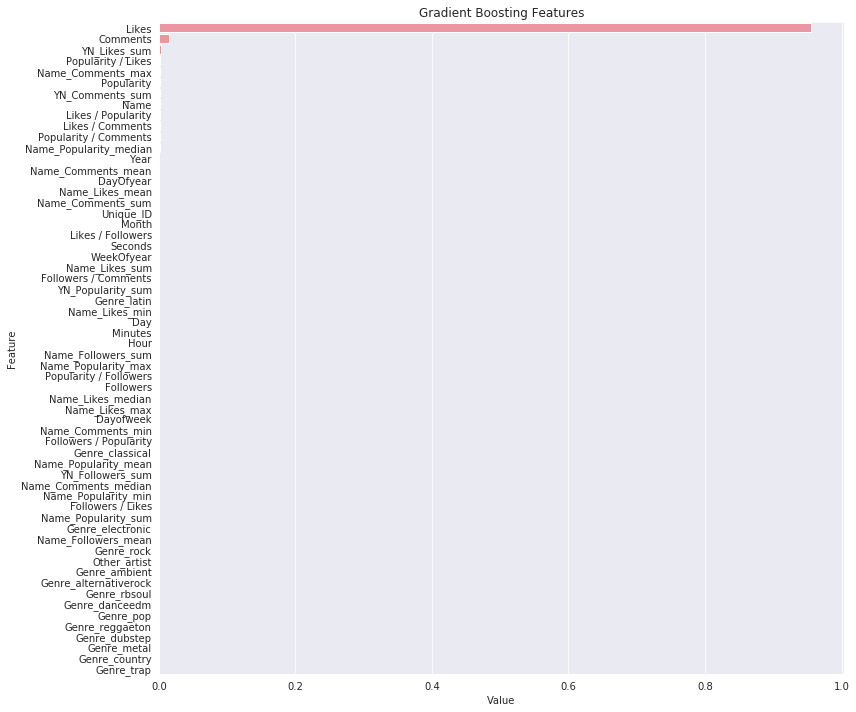

In [32]:
feature_imp = pd.DataFrame(sorted(zip(gb.feature_importances_, X.columns), reverse=True)[:60], columns=['Value','Feature'])
plt.figure(figsize=(12,10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Gradient Boosting Features')
plt.tight_layout()
plt.show()

# Predict on test set

In [33]:
Xtest = test_df

In [34]:
from sklearn.model_selection import KFold

errgb = []
y_pred_totgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=1999)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
             
    gb = GradientBoostingRegressor(learning_rate=0.2, n_estimators=1000, random_state=1999, subsample=0.8)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)

    print('RMSE', sqrt(mean_squared_error(y_test, y_pred)))

    errgb.append(sqrt(mean_squared_error(y_test, y_pred)))
    p = gb.predict(Xtest)
    y_pred_totgb.append(p)

RMSE 775544.0777825735
RMSE 581862.8702434436
RMSE 490973.8800607992
RMSE 991462.4292583055
RMSE 339064.7471166258
RMSE 783771.8817526686
RMSE 559127.2842473952
RMSE 537368.9936748854
RMSE 371667.14893055573
RMSE 695411.8877389459


In [35]:
np.mean(errgb) 

612625.5200806198

In [36]:
final = np.mean(y_pred_totgb,0).round()
final

array([  586.,   534., 15413., ..., -3435.,  3004., -1658.])

In [37]:
for i in range(10):
    sub = pd.DataFrame({'Unique_ID':test['Unique_ID'],'Views': y_pred_totgb[i]})
    sub.to_excel('fold_'+str(i)+'_Output.xlsx', index=False)

In [38]:
sub = pd.DataFrame({'Unique_ID':test['Unique_ID'],'Views': final})
sub.head()

,Unique_ID,Views
0,1120673,586.0
1,1120679,534.0
2,1382621,15413.0
3,1382617,-3034.0
4,1382622,-3034.0


In [39]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(sub)